# Predizione di vittoria nelle battaglie di Pokémon

*Obiettivo:* Costruire e confrontare diversi modelli per predire il vincitore di un duello Pokémon.

### Partecipanti:
- Daniele Merighi
- Luca Palazzini
- Lore

---

## Table of Contents
1. [Parametri e Configurazione](#parametri-e-configurazione)
2. [Import delle Librerie](#import-delle-librerie)
3. [Caricamento e Unione dei Dati](#caricamento-e-unione-dei-dati)
4. [Esplorazione dei Dati](#esplorazione-dei-dati)
5. [Feature Engineering](#feature-engineering)
6. [Analisi delle Correlazioni](#analisi-delle-correlazioni)
7. [Addestramento e Tuning dei Modelli](#addestramento-e-tuning-dei-modelli)
8. [Valutazione dei Modelli](#valutazione-dei-modelli)

# Parametri e Configurazione <a id="parametri-e-configurazione"></a>

In [22]:
# Definizione dei percorsi e dei parametri globali
DATASET_BASE_PATH: str = './datasets'
COMBATS_PATH: str = f"{DATASET_BASE_PATH}/combats.csv"
TYPE_CHART_PATH: str = f"{DATASET_BASE_PATH}/type_chart.csv"
POKEMON_PATH: str = f"{DATASET_BASE_PATH}/pokemon.csv"
MODEL_DIR: str = './models'
RANDOM_STATE: int = 42
# Dimensioni dei set di dati
TEST_SIZE: float = 0.2        # 20% per il test
VALIDATION_SIZE: float = 0.2  # 20% per la validazione
                              # 60% per l'addestramento

# Import delle Librerie <a id="import-delle-librerie"></a>

### ⚙️ Preprocessing dei Dati
Applichiamo tecniche di scaling per le variabili numeriche e di encoding per le variabili categoriche. Questa fase è fondamentale per rendere i dati adatti agli algoritmi di machine learning.

In [23]:
# Librerie base
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sb
import pandas as pd
from typing import Tuple

# Compatibilitá con Jupyter Notebook
%matplotlib inline

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# XGBoost
from xgboost import XGBClassifier

# Salvataggio dei modelli
import joblib
import os

# Caricamento e Unione dei Dati <a id="caricamento-e-unione-dei-dati"></a>

### 📥 Caricamento dei Dati
In questa sezione carichiamo i dataset contenenti le statistiche dei Pokémon e le battaglie effettuate. Uniremo successivamente queste informazioni per ottenere un dataset utile alla predizione dell'esito di uno scontro.

In [24]:
def load_pokemon_data(combats_path: str, pokemon_path: str) -> pd.DataFrame:
   df_combats = pd.read_csv(combats_path)
   df_pokemon = pd.read_csv(pokemon_path, index_col="#").fillna("None")
   # Prerprocessing del campo winner per avere 0 se vince il primo Pokemon e 1 se vince il_So
   df_combats["Winner"] = (df_combats["Winner"] != df_combats["First_pokemon"]).astype(int)
   # Merge first and second Pokémon stats
   return df_combats.merge(
      df_pokemon.add_suffix("_F"), how="left",
      left_on="First_pokemon", right_index=True
   ).merge(
      df_pokemon.add_suffix("_S"), how="left",
      left_on="Second_pokemon", right_index=True
   ).drop(
      columns=["First_pokemon", "Second_pokemon"]
   )

### 📥 Caricamento dei Dati
In questa sezione carichiamo i dataset contenenti le statistiche dei Pokémon e le battaglie effettuate. Uniremo successivamente queste informazioni per ottenere un dataset utile alla predizione dell'esito di uno scontro.

In [25]:
# Caricamento dei DataFrame
df_type_chart = pd.read_csv(TYPE_CHART_PATH).fillna("None")
df_combats: pd.DataFrame = load_pokemon_data(COMBATS_PATH, POKEMON_PATH)

## Esplorazione dei Dati <a id="esplorazione-dei-dati"></a>

## Feature Engineering  <a id="feature-engineering"></a>

In [26]:
def get_dual_multiplier(df, atk_col, def1_col, def2_col, newcol):
   tmp = df_type_chart.rename(columns={
      'attack': atk_col,
      'defense1': def1_col,
      'defense2': def2_col
   })
   df = df.merge(
      tmp[[atk_col, def1_col, def2_col, 'multiplier']],
      on=[atk_col, def1_col, def2_col],
      how='left'
   ).rename(columns={'multiplier': newcol})
   df[newcol] = df[newcol].fillna(1.0)
   return df

In [27]:
df_combats_with_multiplier = df_combats.copy()
df_combats_with_multiplier = get_dual_multiplier(df_combats_with_multiplier, 'Type 1_F', 'Type 1_S', 'Type 2_S', 'F1_to_S')
df_combats_with_multiplier = get_dual_multiplier(df_combats_with_multiplier, 'Type 2_F', 'Type 1_S', 'Type 2_S', 'F2_to_S')
df_combats_with_multiplier = get_dual_multiplier(df_combats_with_multiplier, 'Type 1_S', 'Type 1_F', 'Type 2_F', 'S1_to_F')
df_combats_with_multiplier = get_dual_multiplier(df_combats_with_multiplier, 'Type 2_S', 'Type 1_F', 'Type 2_F', 'S2_to_F')
df_combats_with_multiplier.drop(columns=['Type 1_F', 'Type 2_F', 'Type 1_S', 'Type 2_S'], inplace=True)

In [28]:
# Rimpiazzo delle statistiche con la differenza delle statistiche tra i due pokemon
stats: list[str] = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
for stat in stats:
   df_combats_with_multiplier[f"delta_{stat}"] = df_combats_with_multiplier[f'{stat}_F'] - df_combats_with_multiplier[f'{stat}_S']
   df_combats_with_multiplier.drop(columns=[f'{stat}_F', f'{stat}_S'], inplace=True)

In [29]:
# Rimozione delle colonne non necessarie
df_combats_with_multiplier.drop(columns=['Name_F', 'Name_S', 'Generation_F', 'Generation_S'], inplace=True)

# Addestramento e Tuning dei Modelli <a id="addestramento-e-tuning-dei-modelli"></a>

Per poter addestrare e valutare correttamente i nostri modelli di machine learning, è fondamentale suddividere il dataset a disposizione in sottoinsiemi distinti. Questo processo ci permette di simulare come il modello si comporterebbe su dati nuovi, fornendo una stima più realistica delle sue performance.

### Suddivisione del Dataset

Il codice sottostante implementa una strategia di suddivisione in tre parti: **training set**, **validation set** e **test set**.

1.  **Separazione Iniziale (Test Set)**  
Inizialmente, separiamo la variabile target `Winner` (ciò che vogliamo predire, `y`) dalle features (le variabili usate per la predizione, `X`).  
    Successivamente, una porzione del dataset (definita da `TEST_SIZE`) viene messa da parte come **test set** (`X_test`, `y_test`). Questo set verrà utilizzato **solo alla fine** del processo di sviluppo del modello per ottenere una valutazione finale e imparziale delle sue prestazioni.
    * `random_state=RANDOM_STATE`: Garantisce che la suddivisione sia la stessa ogni volta che il codice viene eseguito, rendendo i risultati riproducibili.
    * `stratify=y`: Assicura che la proporzione delle classi nella variabile target `y` sia mantenuta sia nel set temporaneo (`X_temp`, `y_temp`) che nel test set. Questo è cruciale in problemi di classificazione, specialmente con classi sbilanciate, per evitare che uno dei set contenga una rappresentazione distorta delle classi.

2.  **Separazione Training e Validation Set**  
    Il restante dataset temporaneo (`X_temp`, `y_temp`) viene a sua volta suddiviso in:  
    * **Training set** (`X_train`, `y_train`): Utilizzato per addestrare il modello. Il modello "impara" dai pattern presenti in questi dati.  
    * **Validation set** (`X_val`, `y_val`): Utilizzato durante la fase di sviluppo per la messa a punto degli iperparametri del modello (tuning) e per confrontare le performance di diversi modelli. Questo aiuta a prevenire l'overfitting sul training set. La dimensione è calcolata in modo da rispettare la proporzione `VALIDATION_SIZE` rispetto al dataset originale. Anche qui, `stratify=y_temp` mantiene la proporzione delle classi.

In [30]:
# Funzione per addestrare i modelli e calcolare il punteggio
def train_and_score(pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    return accuracy_score(y_test, preds)

# Creazione del dataset di addestramento e test
y: pd.Series = df_combats_with_multiplier['Winner']
X: pd.DataFrame = df_combats_with_multiplier.drop(columns=['Winner'])
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=VALIDATION_SIZE / (1.0 - TEST_SIZE),
    random_state=RANDOM_STATE,
    stratify=y_temp
)

### Preprocessing dei Dati
Si procede alla preparazione delle feature prima dell’addestramento del modello. In particolare, si distinguono le variabili numeriche da quelle categoriche, e si applicano trasformazioni appropriate a ciascun tipo.

`labels_categoriche`: contiene i nomi delle variabili categoriche del dataset. In questo caso, si tratta di variabili booleane che indicano se il primo (F) o il secondo (S) Pokémon coinvolto nel combattimento è leggendario. Tali variabili sono fondamentali poiché l’essere leggendario è spesso associato a migliori statistiche di base.

`processed_numerical_columns`: tramite select_dtypes, vengono selezionate automaticamente tutte le colonne numeriche da preprocessare. Questo garantisce una scalabilità automatica del codice al variare delle feature numeriche presenti in X.

ColumnTransformer:

Utilizza due trasformatori principali:

* `StandardScaler()` per normalizzare tutte le feature numeriche, centrando le distribuzioni intorno allo 0 con varianza unitaria. Questo è particolarmente utile per modelli sensibili alle scale (es. SVM, regressione logistica).

* `OneHotEncoder(drop='first')` per convertire le feature categoriche in variabili dummy, evitando la trappola della multicollinearità rimuovendo la prima categoria.

L’opzione `sparse_output=False` impone un output denso per compatibilità con pipeline che non gestiscono bene matrici sparse.

`sparse_threshold=0.0` assicura che anche in presenza di feature categoriche, l’output sia denso e uniforme per tutte le trasformazioni.

In [31]:
# Codifica delle variabili categoriche
# Otteniamo le label delle variabili categoriche
labels_categoriche: list[str] = ['Legendary_F', 'Legendary_S']
# Preprocessing delle variabili categoriche e numeriche
processed_numerical_columns: list[str] = X.select_dtypes(include=np.number).columns.tolist();
column_encoder: ColumnTransformer = ColumnTransformer(
    transformers=[
    ("numeric", StandardScaler(), processed_numerical_columns),
    ("categorical", OneHotEncoder(drop='first', sparse_output=False), labels_categoriche),
], sparse_threshold=0.0)

Si implementa un **modello dummy**, che funge da **baseline** per confrontare le prestazioni degli altri modelli più complessi. Non apprende nulla dai dati, ma produce previsioni casuali in base a una strategia predefinita.



In [32]:
# Modello dummy
dummy_model: Pipeline = Pipeline([
    ('column_encoder', column_encoder),
    ('classifier', DummyClassifier(strategy='uniform', random_state=RANDOM_STATE))
])

Si implementa un **modello lineare** tramite **regressione logistica** con penalizzazione L1 (noto anche come Lasso Logistic Regression). Questo tipo di modello è particolarmente utile per la **selezione automatica delle feature** e per garantire **sparsità** nei coefficienti, migliorando interpretabilità e generalizzazione.

Viene usato:

* `penalty='l1'`: applica una penalizzazione L1 ai coefficienti, inducendo molti di essi a zero. Questo è utile quando si vuole automatizzare la selezione delle feature, lasciando solo quelle più informative.

* `solver='liblinear'`: è l’algoritmo ottimizzatore compatibile con la penalizzazione L1. È adatto a dataset di dimensioni contenute o moderate e garantisce una buona convergenza.

In [33]:
# Modello lineare
linear_model: Pipeline = Pipeline([
    ('column_encoder', column_encoder),
    ('logistic_l1', LogisticRegression(penalty='l1', solver='liblinear'))
])

Si implementa un **modello di classificazione basato su Random Forest**, una delle tecniche di machine learning supervisionato più robuste e diffuse, in particolare per problemi di classificazione binaria come la previsione del vincitore in una battaglia Pokémon.

È un modello ensemble che costruisce molteplici alberi decisionali e li combina per migliorare l'accuratezza e ridurre l'overfitting.

L'argomento `n_estimators=100` specifica il numero di alberi nella foresta, garantendo una buona capacità di generalizzazione.

Il parametro `random_state` assicura ripetibilità dell’esperimento.

In [34]:
# Modello decision tree
decision_tree_model: Pipeline = Pipeline([
    ('column_encoder', column_encoder),
    ("tree", RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE))
])

Si implementa un modello predittivo avanzato tramite **XGBoost (Extreme Gradient Boosting)**, uno degli algoritmi più performanti e utilizzati nel machine learning moderno, specialmente in contesti competitivi e industriali.

E' una variante estremamente efficiente del Gradient Boosting Decision Tree (GBDT).

Il parametro `eval_metric='logloss'` specifica la funzione di perdita da minimizzare durante il training, adatta a problemi di classificazione binaria.



In [35]:
# Modello xgboost
xgboost_model: Pipeline = Pipeline([
   ('column_encoder', column_encoder),
   ("xgboost", XGBClassifier(eval_metric='logloss', random_state=RANDOM_STATE))
])

Quando si costruisce un modello di machine learning, come XGBoost, la sua performance dipende molto dai parametri iper (o iperparametri) che regolano il comportamento del modello. Tali parametri non vengono appresi automaticamente dal modello durante il training, ma devono essere impostati a priori dall’utente.

Esempi di iperparametri in XGBoost sono:

* n_estimators: numero di alberi da costruire (numero di iterazioni boosting).

* max_depth: profondità massima di ogni albero.

* learning_rate: velocità con cui il modello si adatta agli errori.

La grid search è un metodo esaustivo per trovare la miglior combinazione di iperparametri da un insieme predefinito di valori. 

Per valutare la robustezza della performance di ogni combinazione, si usa la cross-validation:

* Il dataset di training viene diviso in k-fold

* Il modello viene allenato e valutato 3 volte, ogni volta usando un fold diverso per la validazione e gli altri due per l’allenamento.

* La performance finale è la media delle 3 valutazioni.

`grid_xgb.best_estimator_ ` è il modello completo, addestrato con i parametri ottimali, pronto per essere usato su dati nuovi.

In [36]:
# Creazione di una griglia di ricerca per ottimizzare i parametri del modello XGBoost
param_grid: dict = {
   'xgboost__n_estimators': [200, 300, 400],
   'xgboost__max_depth': [8, 9, 10],
   'xgboost__learning_rate': [0.05, 0.1, 0.15]
}
grid_xgb: GridSearchCV = GridSearchCV(xgboost_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train)
print(f"Best parameters: {grid_xgb.best_params_}")
# Modello xgboost
xgboost_grid_model: Pipeline = grid_xgb.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'xgboost__learning_rate': 0.15, 'xgboost__max_depth': 9, 'xgboost__n_estimators': 300}


In [37]:
# Addestramento e valutazione dei modelli creati
models: list = [dummy_model, linear_model, decision_tree_model, xgboost_model, xgboost_grid_model]
model_names: list = ['Dummy', 'Logistic Regression', 'Decision Tree', 'XGBoost', 'XGBoost with Grid Search']
# Visualizzazione dei risultati dei modelli
for model, name in zip(models, model_names):
   score: float = train_and_score(model, X_train, y_train, X_test, y_test)
   print(f"{name} score: {score:.4f}")

Dummy score: 0.5035
Logistic Regression score: 0.8762
Decision Tree score: 0.9601
XGBoost score: 0.9616
XGBoost with Grid Search score: 0.9627


In [38]:
# Salvataggio dei modelli
if not os.path.exists('models'):
   os.makedirs('models')

for model, name in zip(models, model_names):
   print(f"Saving model: {name}")
   joblib.dump(model, f'models/{name.replace(" ", "_").lower()}.joblib')

Saving model: Dummy
Saving model: Logistic Regression
Saving model: Decision Tree
Saving model: XGBoost
Saving model: XGBoost with Grid Search


# Valutazione dei Modelli <a id="valutazione-dei-modelli"></a>

In [39]:
model_names = ['Dummy', 'Logistic Regression', 'Decision Tree', 'XGBoost', 'XGBoost Optimized']

In [40]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def extended_validation(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    print(title)
    print(classification_report(y_test, y_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    if y_proba is not None:
        print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# Applica a tutti i modelli
for i, model in enumerate(models[1:]):
    model.fit(X_train, y_train) # Ri-addestra su tutto il training set
    extended_validation(model, X_test, y_test, title=f"Classification Report: {model_names[i+1]}")

Classification Report: Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      4720
           1       0.88      0.89      0.88      5280

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Confusion Matrix:
[[4058  662]
 [ 576 4704]]
ROC AUC Score: 0.9238
Classification Report: Decision Tree
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4720
           1       0.96      0.96      0.96      5280

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Confusion Matrix:
[[4514  206]
 [ 193 5087]]
ROC AUC Score: 0.9914
Classification Report: XGBoost
              precision    recall  f1-score   support

           0       0.96      0.96      0.96   

- **Asse X**: Esempi di training usati (da pochi a tutto il dataset)  
- **Asse Y**: Accuratezza (0.0-1.0)  
- **Linea blu**: Training score (performance sui dati di addestramento)  
- **Linea arancione**: Validation score (performance su dati nuovi)

### **Modello Ben Addestrato**
- Training e validation score convergono  
- Validation score alta (>0.95)  
- Piccolo gap (<0.02) tra le curve

### **Overfitting**
- Training score ~100%  
- Validation score più bassa  
- Grande gap tra le curve

### **Underfitting**  
- Entrambe le curve basse
- Poco gap ma accuracy insufficiente

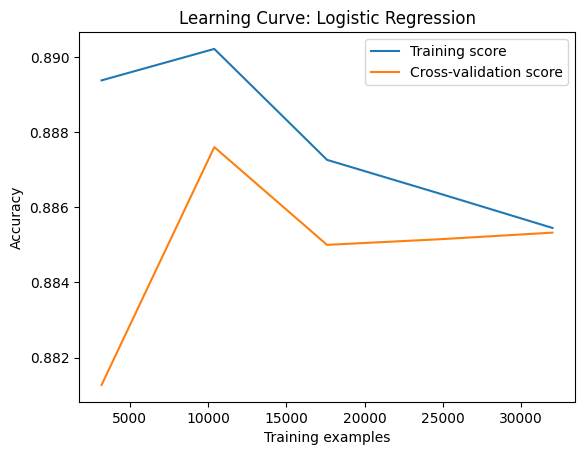

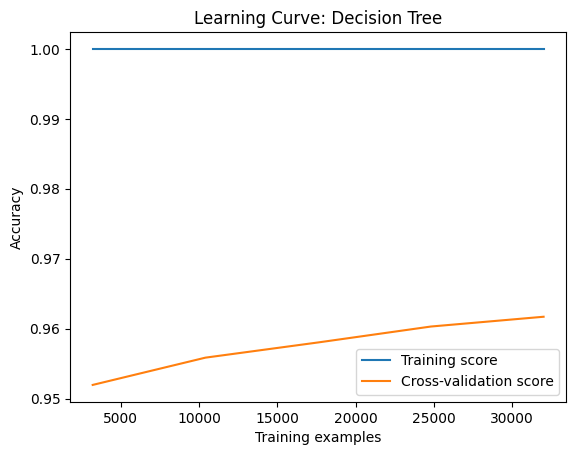

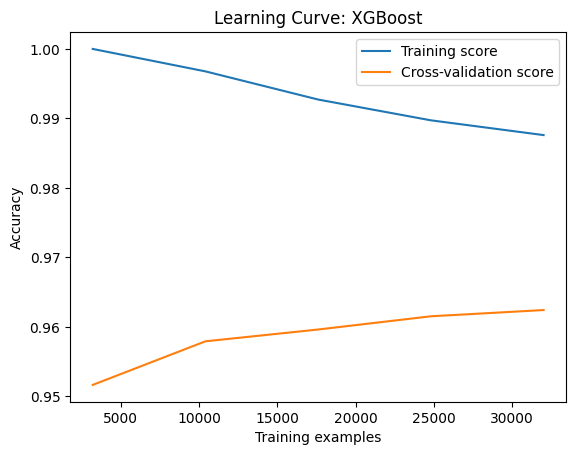

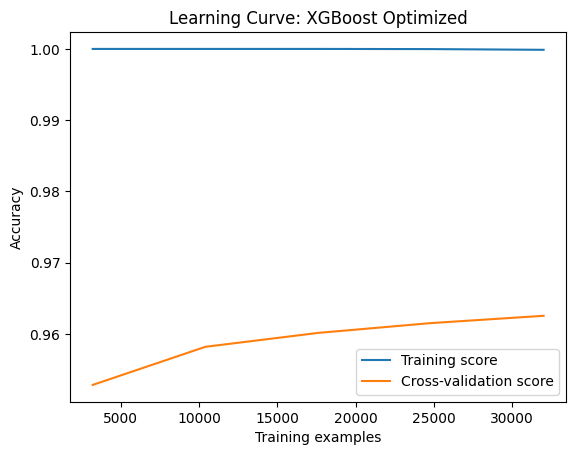

In [41]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5),
        scoring='accuracy'
    )
    
    plt.figure()
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(title)
    plt.show()

for i, model in enumerate(models[1:]):  # Escludi dummy model
    plot_learning_curve(
        model, 
        X_temp, 
        y_temp,
        title=f"Learning Curve: {model_names[i+1]}"
    )

In [45]:
importances: XGBClassifier = xgboost_model.named_steps['xgboost']
importances = importances.feature_importances_
features = column_encoder.set_output(transform='pandas').fit_transform(data_transformer.set_output(transform='pandas').fit_transform(X_train)).columns
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance

NameError: name 'data_transformer' is not defined